In [29]:
from __future__ import annotations

import os

os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
os.environ['ARCHITECTURE'] = 'convnext'
os.environ['TILE_SIZE'] = '50'
os.environ['PRETRAINED'] = '1'
os.environ['OVERLAP'] = '25'
os.environ['BATCH_SIZE'] = '50'
os.environ['EXPERIMENTS_NAME'] = 'multivariate'
os.environ['EPOCHS'] = '10'
os.environ['NUM_SAMPLES'] = '5'
os.environ['TRAIN_NUM_SAMPLES'] = '1000'
os.environ['OVERWRITE'] = '0'

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ray
import seaborn as sns
from ray.tune import Result
from scipy.interpolate import UnivariateSpline

from landnet.config import CPUS, EXPERIMENTS_NAME, FIGURES_DIR, GPUS, MODELS_DIR
from landnet.enums import GeomorphometricalVariable
from landnet.logger import create_logger
from landnet.modelling import torch_clear
from landnet.modelling.classification.train import train_model
from landnet.modelling.tune import MetricSorter, get_results_df
from landnet.plots import ExperimentsResultPlot

if GPUS:
    torch_clear()

logger = create_logger(__name__)

if not ray.is_initialized():
    ray.init(num_cpus=CPUS, num_gpus=GPUS)

# Configs

In [31]:
# used to only keep best checkpoint; if this does not work also try 'val_f2_score'
sorter = MetricSorter('val_f2_score', 'max')

# Train multivariate models

In [32]:
def expanding_windows(seq, start: int = 0):
    for i in range(start, len(seq)):
        yield seq[: i + 1]


univariate_results_df = pd.read_csv(
    MODELS_DIR / 'univariate' / 'results.csv', index_col='model'
).sort_values(by='validation_f2_score', ascending=False)

results = []
for variables in expanding_windows(
    univariate_results_df.index.tolist(), start=1
):
    logger.info(
        'Tuning a model with %i variables: %r' % (len(variables), variables)
    )
    model_name = f'{len(variables)}_variables'
    best_result = train_model(
        variables=[
            GeomorphometricalVariable(variable) for variable in variables
        ],
        model_name=model_name,
        sorter=sorter,
        out_dir=MODELS_DIR / EXPERIMENTS_NAME / model_name,
    )
    results.append(best_result)
df = get_results_df(results, sorter, fix_missing_predictions=True)
df.to_csv(MODELS_DIR / EXPERIMENTS_NAME / 'results.csv', index=False)

INFO: Tuning a model with 2 variables: ['area', 'slope']
INFO: Skipping training for [<GeomorphometricalVariable.REAL_SURFACE_AREA: 'area'>, <GeomorphometricalVariable.SLOPE: 'slope'>] as /media/alex/alex/python-modules-packages-utils/landnet/models/multivariate/2_variables already exists.
INFO: Tuning a model with 3 variables: ['area', 'slope', 'tri']
INFO: Skipping training for [<GeomorphometricalVariable.REAL_SURFACE_AREA: 'area'>, <GeomorphometricalVariable.SLOPE: 'slope'>, <GeomorphometricalVariable.TERRAIN_RUGGEDNESS_INDEX: 'tri'>] as /media/alex/alex/python-modules-packages-utils/landnet/models/multivariate/3_variables already exists.
INFO: Tuning a model with 4 variables: ['area', 'slope', 'tri', 'shade']
INFO: Skipping training for [<GeomorphometricalVariable.REAL_SURFACE_AREA: 'area'>, <GeomorphometricalVariable.SLOPE: 'slope'>, <GeomorphometricalVariable.TERRAIN_RUGGEDNESS_INDEX: 'tri'>, <GeomorphometricalVariable.HILLSHADE: 'shade'>] as /media/alex/alex/python-modules-packa

In [33]:
df

,model,train_accuracy,train_f1_score,train_f2_score,train_f3_score,train_negative_predictive_value,train_positive_predictive_value,train_roc_auc,train_sensitivity,train_specificity,...,validation_negative_predictive_value,validation_positive_predictive_value,validation_roc_auc,validation_sensitivity,validation_specificity,learning_rate,batch_size,tile_config,checkpoint,epoch
0,2_variables,0.918125,0.814710,0.899438,0.931737,0.991604,0.704156,0.984675,0.966443,0.907066,...,0.964286,0.822335,0.971332,0.957164,0.848321,0.000031,8,"TileConfig(size=TileSize(width=50, height=50),...",checkpoint_000006,6
1,3_variables,0.860625,0.722981,0.856386,0.912512,0.993596,0.573964,0.987085,0.976510,0.834101,...,0.978836,0.783175,0.977955,0.976366,0.801733,0.000031,8,"TileConfig(size=TileSize(width=50, height=50),...",checkpoint_000008,8
2,4_variables,0.882500,0.758974,0.884110,0.935525,0.998211,0.614108,0.987742,0.993289,0.857143,...,0.972938,0.796117,0.969925,0.968981,0.817985,0.000015,4,"TileConfig(size=TileSize(width=50, height=50),...",checkpoint_000006,6
3,5_variables,0.865000,0.731343,0.865724,0.922208,0.996344,0.581028,0.987317,0.986577,0.837174,...,0.976290,0.747452,0.967554,0.974889,0.758397,0.000025,8,"TileConfig(size=TileSize(width=50, height=50),...",checkpoint_000006,6
4,6_variables,0.916250,0.812325,0.901741,0.936088,0.993243,0.697115,0.987868,0.973154,0.903226,...,0.969543,0.804187,0.969760,0.964549,0.827736,0.000031,8,"TileConfig(size=TileSize(width=50, height=50),...",checkpoint_000008,8
5,7_variables,0.865625,0.732919,0.868158,0.925055,0.997255,0.581854,0.991496,0.989933,0.837174,...,0.972549,0.785629,0.972970,0.968981,0.806067,0.000031,8,"TileConfig(size=TileSize(width=50, height=50),...",checkpoint_000009,9
6,8_variables,0.907500,0.795580,0.889988,0.926641,0.991482,0.676056,0.986430,0.966443,0.894009,...,0.964912,0.809227,0.968315,0.958641,0.834236,0.000031,8,"TileConfig(size=TileSize(width=50, height=50),...",checkpoint_000008,8
7,9_variables,0.926875,0.833570,0.917345,0.949142,0.995816,0.723457,0.990397,0.983221,0.913979,...,0.965686,0.827806,0.970725,0.958641,0.853738,0.000025,8,"TileConfig(size=TileSize(width=50, height=50),...",checkpoint_000007,7
8,10_variables,0.913750,0.808864,0.903465,0.940116,0.994898,0.688679,0.987639,0.979866,0.898618,...,0.966625,0.821745,0.971271,0.960118,0.847237,0.000025,8,"TileConfig(size=TileSize(width=50, height=50),...",checkpoint_000008,8
9,11_variables,0.873125,0.743363,0.872404,0.925984,0.996387,0.596349,0.988117,0.986577,0.847158,...,0.980690,0.757714,0.972412,0.979321,0.770314,0.000025,8,"TileConfig(size=TileSize(width=50, height=50),...",checkpoint_000006,6


In [34]:
df['model'] = df['model'].str.replace('_variables', '').astype(int)
df = df.sort_values(by='model')
plots = ExperimentsResultPlot(df)

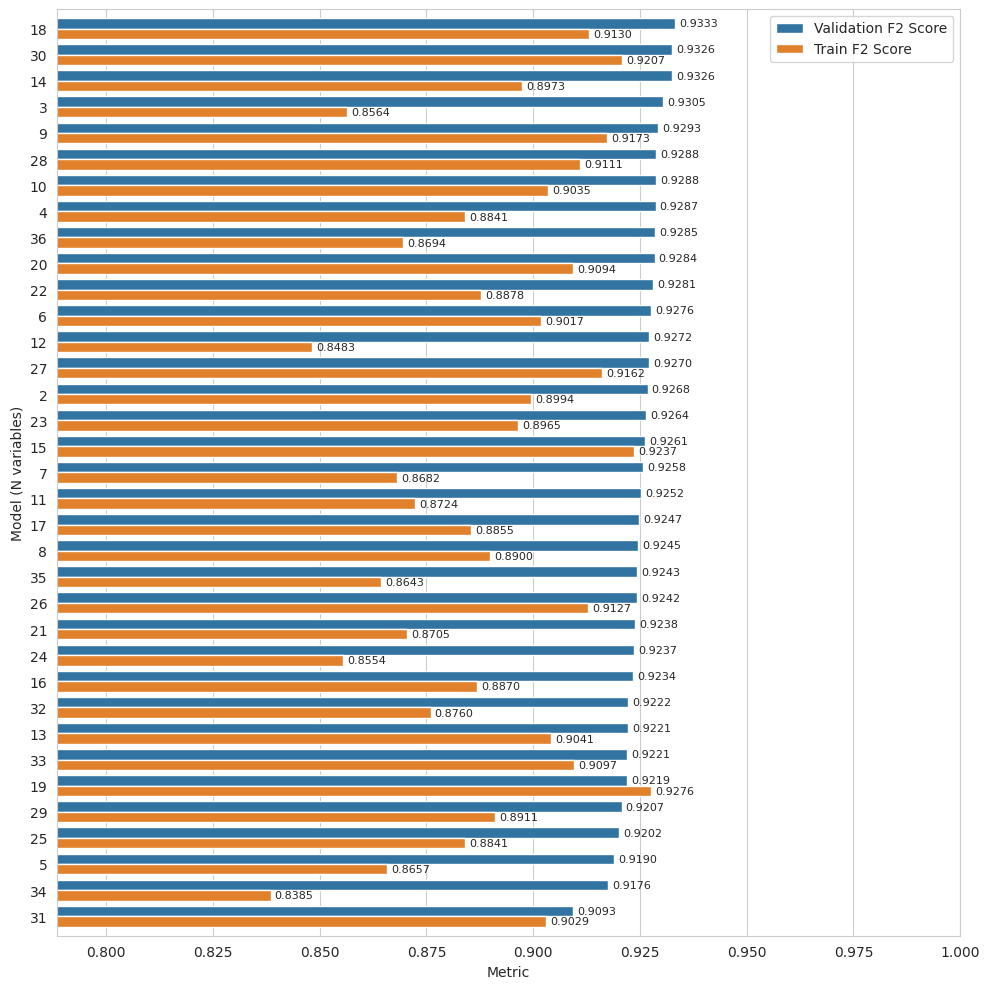

In [35]:
fig, ax = plt.subplots(figsize=(10, 10))
plots.model_bar_plot(
    value_vars=['validation_f2_score', 'train_f2_score'], ax=ax
)
ax.set_ylabel('Model (N variables)')
fig.savefig(FIGURES_DIR / 'multivariate_f2_score.png', dpi=300)

# Cubic spline fit of test_f2_score

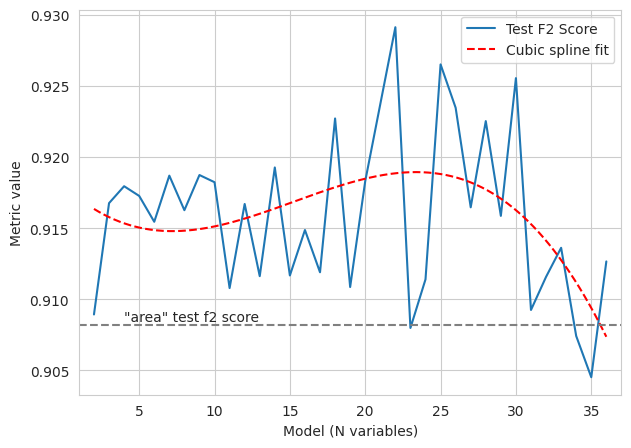

In [36]:
sns.set_style('whitegrid')

# Spline fit
y = df['test_f2_score']
x = np.arange(2, y.shape[0] + 2)
spline = UnivariateSpline(x, y)
x_fine = np.linspace(x.min(), x.max(), 500)
y_fine = spline(x_fine)

# Plot
fig, ax = plt.subplots(figsize=(7, 5))
plots.model_line_plot(value_vars=['test_f2_score'], ax=ax)
ax.plot(x_fine, y_fine, '--', label='Cubic spline fit', color='red')
ax.hlines(0.908163, x.min() - 1, x.max() + 1, color='gray', linestyles='--')
ax.set_xlim(x.min() - 1, x.max() + 1)
ax.text(4, 0.9085, '"area" test f2 score')
ax.legend()
ax.set_xlabel('Model (N variables)')
ax.set_ylabel('Metric value')
fig.savefig(
    FIGURES_DIR / 'multivariate_f2_score_lineplot.png',
    dpi=300,
    bbox_inches='tight',
)